## Solving bidomain equations on the slice with the Beeler-Reuter model and ischemia

### Importing required libraries

In [1]:
%cd ../../..
from src.models.dynamics_models import *
from src.models.cell_models import *
from src.utils import *
import ufl

/home/drvinko/Desktop/Modeliranje-biofizike-srcanog-tkiva


### Defining a domain, cell model and dynamics model and visualizing initial data

In [2]:
domain = heart_slice(0.09)
x = ufl.SpatialCoordinate(domain)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 40%] Meshing curve 2 (Nurb)
Info    : [ 70%] Meshing curve 3 (Nurb)
Info    : Done meshing 1D (Wall 0.109841s, CPU 0.057335s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.19596s, CPU 0.151641s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 3.6356e-05s, CPU 2.7e-05s)
Info    : 4400 nodes 8775 elements


In [3]:
class CellModel(ReparametrizedFitzHughNagumo):
    def apply_current(self):
        locator = lambda x: (x[0] - 4.3) ** 2 + (x[1] - 1.7) ** 2 < 0.3**2
        cells = fem.locate_dofs_geometrical(self.V1, locator)
        self.I_app.x.array[cells] = np.full_like(cells, 10)
        self.I_app_duration = 20

In [22]:
class Model(BidomainModel):
    def initial_V_m(self):
        self.V_m_n.x.array[:] = -85

    def conductivity(self):
        # Muscle fibres
        x_c, y_c = 0.2, 1
        self.fibers = ufl.as_vector(
            [
                -(x[1] - y_c) / ufl.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
                (x[0] - x_c) / ufl.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
            ]
        )

        # Healthy conductivities
        self.M_i = self.SIGMA_IT * ufl.Identity(2) + (
            self.SIGMA_IL - self.SIGMA_IT
        ) * ufl.outer(self.fibers, self.fibers)
        self.M_e = self.SIGMA_ET * ufl.Identity(2) + (
            self.SIGMA_EL - self.SIGMA_ET
        ) * ufl.outer(self.fibers, self.fibers)

    def ischemia(self):
        x_c, y_c = 4.0, 3.0
        return lambda x: (x[0] - x_c) ** 2/10 + (x[1] - y_c) ** 2*10 < 0.5**2, 10, 10

In [23]:
cell_model = CellModel(domain)
model = Model(domain, cell_model)

In [24]:
cell_model.plot_I_app(
    show_mesh=False,
    function_name="",
    camera_direction="xy",
    save_to="figures/slice/ischemia_MFN_applied_current.pdf",
)

Widget(value='<iframe src="http://localhost:43505/index.html?ui=P_0x7f4f3a9a5310_9&reconnect=auto" class="pyvi…

In [25]:
model.plot_ischemia(
    show_mesh=False,
    function_name="",
    camera_direction="xy",
    save_to="figures/slice/ischemia_MFN_ischemic_area.pdf",
)

Widget(value='<iframe src="http://localhost:43505/index.html?ui=P_0x7f4f3a95b050_10&reconnect=auto" class="pyv…

### Solving equations with given parameters

In [8]:
model.solve(
    T=1000,
    steps=1000,
    save_to="slice/ischemia_MFN.mp4",
    signal_point=[1.0, 3.0, 0.0],
    camera_direction="xy",
    checkpoints=[100,200,300,400,500,600,700,800,900,1000],
    checkpoint_file='figures/slice/ischemia_MFN'
)

Solving problem: 100%|██████████| 1000/1000 [39:42<00:00,  2.38s/it]


### Plotting a fiber orientations

In [9]:
x_c, y_c = 0.2, 1
plot_vector_field(
    domain,
    lambda x: (
        -(x[1] - y_c) / np.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        (x[0] - x_c) / np.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        0,
    ),
    0.03,
    0.3,
    camera_direction='xy',
    save_to='figures/slice/ischemia_MFN_fibers.pdf'
)

Widget(value='<iframe src="http://localhost:40227/index.html?ui=P_0x7fd0347384d0_2&reconnect=auto" class="pyvi…

### Plotting a final plot of transmembrane potential

In [10]:
plot_function(model.V_m_n, "V_m", show_mesh=False)

### Plotting a transmembrane potential in a given signal point

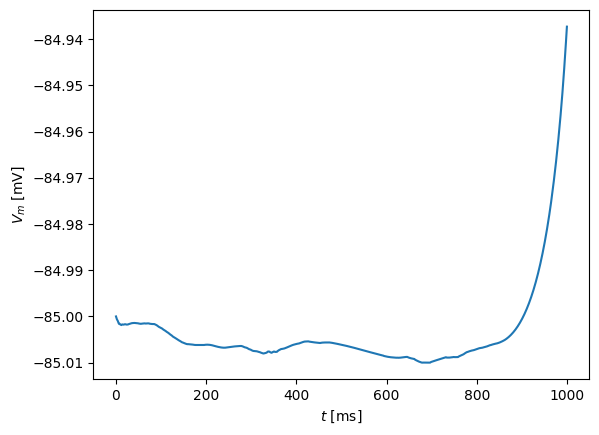

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('e800a1feaff7af7ab74bd216bfe0d4fb_16998d')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/wslink/protocol.py", line 332, in onMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 30, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: 'e800a1feaff7af7ab74bd216bfe0d4fb_16998d'

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('5c77a80993aec469233ebf3607e60f35_16998d

In [11]:
model.plot_signal()